In [2]:
# Step 1: Install Necessary Libraries
!pip install "optimum-neuron==0.0.13" "diffusers==0.21.4" boto3 --upgrade
!pip install "sagemaker>=2.197.0" --upgrade

  Using cached optimum_neuron-0.0.13-py3-none-any.whl.metadata (14 kB)
  Using cached diffusers-0.21.4-py3-none-any.whl.metadata (18 kB)
  Using cached transformers-4.44.2-py3-none-any.whl.metadata (43 kB)
  Using cached accelerate-0.23.0-py3-none-any.whl.metadata (18 kB)
  Using cached optimum-1.21.4-py3-none-any.whl.metadata (19 kB)
  Using cached huggingface_hub-0.24.6-py3-none-any.whl.metadata (13 kB)
  Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (679 bytes)
  Using cached safetensors-0.4.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl.metadata (12 kB)
  Using cached transformers-4.43.4-py3-none-any.whl.metadata (43 kB)
  Using cached datasets-2.21.0-py3-none-any.whl.metadata (21 kB)
  Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached sentencepiece-0.2.0-cp310-cp310-manylin

In [6]:
# Step 2: Import Necessary Libraries
import boto3
from io import BytesIO
from PIL import Image
from optimum.neuron import NeuronStableDiffusionImg2ImgPipeline

In [5]:
# import transformers
# transformers.utils.move_cache()

0it [00:00, ?it/s]

In [8]:
%cd /home/ec2-user/sdxl_neuron/code

/home/ec2-user/sdxl_neuron/code


In [10]:
%%writefile /home/ec2-user/sdxl_neuron/code/inference2.py
import os
import torch
import torch_neuronx
from PIL import Image
from io import BytesIO
import base64
from optimum.neuron import NeuronStableDiffusionImg2ImgPipeline

# Environment setup
os.environ["NEURON_RT_NUM_CORES"] = "2"

# Load the pipeline
pipeline = NeuronStableDiffusionImg2ImgPipeline.from_pretrained("{model_dir}")

# Function to decode base64 image
def decode_base64_image(image_string):
    base64_image = base64.b64decode(image_string)
    buffer = BytesIO(base64_image)
    return Image.open(buffer)

# Function to encode image to base64
def encode_base64_image(image):
    buffer = BytesIO()
    image.save(buffer, format="JPEG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

def predict_fn(input_data):
    # Load the image
    image = decode_base64_image(input_data['image'])
    
    # Run the model
    generated_image = pipeline(prompt=input_data['prompt'], image=image, strength=0.5, guidance_scale=7.5).images[0]
    
    # Return the generated image in base64
    return {"generated_image": encode_base64_image(generated_image)}


Writing /home/ec2-user/sdxl_neuron/code/inference2.py


In [11]:
!ls /home/ec2-user/sdxl_neuron/code/

inference2.py  inference.py


In [12]:
!cat /home/ec2-user/sdxl_neuron/code/inference2.py

import os
import torch
import torch_neuronx
from PIL import Image
from io import BytesIO
import base64
from optimum.neuron import NeuronStableDiffusionImg2ImgPipeline

# Environment setup
os.environ["NEURON_RT_NUM_CORES"] = "2"

# Load the pipeline
pipeline = NeuronStableDiffusionImg2ImgPipeline.from_pretrained("{model_dir}")

# Function to decode base64 image
def decode_base64_image(image_string):
    base64_image = base64.b64decode(image_string)
    buffer = BytesIO(base64_image)
    return Image.open(buffer)

# Function to encode image to base64
def encode_base64_image(image):
    buffer = BytesIO()
    image.save(buffer, format="JPEG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

def predict_fn(input_data):
    # Load the image
    image = decode_base64_image(input_data['image'])
    
    # Run the model
    generated_image = pipeline(prompt=input_data['prompt'], image=image, strength=0.5, guidance_scale=7.5).images[0]
    
    # Return the generated image in bas

In [18]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")
assert sess.boto_region_name in ["us-east-2", "us-east-1"] , "region must be us-east-2 or us-west-2, due to instance availability"

sagemaker role arn: arn:aws:iam::730335623048:role/service-role/SageMaker-ExecutionRole-20240823T144432
sagemaker bucket: sagemaker-us-east-1-730335623048
sagemaker session region: us-east-1


In [14]:
%cd /home/ec2-user/sdxl_neuron
!ls -R


/home/ec2-user/sdxl_neuron
.:
code		  README.md	text_encoder_2	unet
model_index.json  scheduler	tokenizer	vae_decoder
model.tar.gz	  text_encoder	tokenizer_2	vae_encoder

./code:
inference2.py  inference.py

./scheduler:
scheduler_config.json

./text_encoder:
config.json  model.neuron

./text_encoder_2:
config.json  model.neuron

./tokenizer:
merges.txt  special_tokens_map.json  tokenizer_config.json  vocab.json

./tokenizer_2:
merges.txt  special_tokens_map.json  tokenizer_config.json  vocab.json

./unet:
config.json  model.neuron

./vae_decoder:
config.json  model.neuron

./vae_encoder:
config.json  model.neuron


In [15]:
# create a model.tar.gz archive with all the model artifacts and the inference2.py script.
#Writing /home/ec2-user/sdxl_neuron/code/inference2.py
%cd /home/ec2-user/sdxl_neuron
!tar zcvf model_v2.tar.gz *
%cd ..

/home/ec2-user/sdxl_neuron
code/
code/inference.py
code/inference2.py
model_index.json
model.tar.gz
README.md
scheduler/
scheduler/scheduler_config.json
text_encoder/
text_encoder/config.json
text_encoder/model.neuron
text_encoder_2/
text_encoder_2/config.json
text_encoder_2/model.neuron
tokenizer/
tokenizer/special_tokens_map.json
tokenizer/merges.txt
tokenizer/tokenizer_config.json
tokenizer/vocab.json
tokenizer_2/
tokenizer_2/merges.txt
tokenizer_2/special_tokens_map.json
tokenizer_2/tokenizer_config.json
tokenizer_2/vocab.json
unet/
unet/config.json
unet/model.neuron
vae_decoder/
vae_decoder/config.json
vae_decoder/model.neuron
vae_encoder/
vae_encoder/config.json
vae_encoder/model.neuron
/home/ec2-user


In [20]:
from sagemaker.s3 import S3Uploader

# Path to your model_v2.tar.gz file
local_path = "/home/ec2-user/sdxl_neuron/model_v2.tar.gz"

# Create S3 URI using the default bucket
s3_model_path = f"s3://{sess.default_bucket()}/neuronx/sdxl_img2img"

# Upload the new tar file (model_v2.tar.gz) to the specified S3 bucket and path
s3_model_uri = S3Uploader.upload(local_path=local_path, desired_s3_uri=s3_model_path)
print(f"Model artifacts uploaded to {s3_model_uri}")

Model artifacts uploaded to s3://sagemaker-us-east-1-730335623048/neuronx/sdxl_img2img/model_v2.tar.gz


In [21]:
from sagemaker.huggingface.model import HuggingFaceModel

# Create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=s3_model_uri,        # path to your model.tar.gz on S3
   role=role,                      # IAM role with permissions to create an endpoint
   transformers_version="4.34.1",  # transformers version used
   pytorch_version="1.13.1",       # PyTorch version used
   py_version='py310',             # Python version used
   model_server_workers=1,         # Number of workers for the model server
)

# Deploy the endpoint
predictor = huggingface_model.deploy(
    initial_instance_count=1,      # Number of instances
    instance_type="ml.inf2.xlarge", # AWS Inferentia Instance
    volume_size=100,
)

# # Retrieve and print the endpoint name
# endpoint_name = predictor.endpoint_name
# print(f"Model deployed to endpoint: {endpoint_name}")

Your model is not compiled. Please compile your model before using Inferentia.


-------------!Model deployed to endpoint: huggingface-pytorch-inference-neuronx-2024-08-30-08-41-54-644


In [34]:
import boto3
import base64
import json
from io import BytesIO
from PIL import Image
from diffusers.utils import make_image_grid
import matplotlib.pyplot as plt

# Initialize clients
sagemaker_runtime = boto3.client('sagemaker-runtime')
s3_client = boto3.client('s3')

def run_inference(predictor, bucket_name, image_key, prompt, guidance_scale=7.5):
    # Step 1: Load the Initial Image from S3
    s3_client = boto3.client('s3')
    s3_response = s3_client.get_object(Bucket=bucket_name, Key=image_key)
    init_image = Image.open(BytesIO(s3_response['Body'].read())).convert("RGB")
    init_image = init_image.resize((512, 512))
    
    # Step 2: Convert the Image to Base64
    buffer = BytesIO()
    init_image.save(buffer, format="JPEG")
    base64_image = base64.b64encode(buffer.getvalue()).decode("utf-8")
    
    # Step 3: Run Prediction
    response = predictor.predict(data={
        "inputs": prompt,
        "image": base64_image,
        "parameters": {
            "guidance_scale": guidance_scale,
            "num_inference_steps": 25,
            "negative_prompt": "disfigured, ugly, deformed"
        }
    })
    
    # Step 4: Decode the Base64 Response Image
    generated_image_base64 = response['generated_images'][0]
    generated_image = Image.open(BytesIO(base64.b64decode(generated_image_base64)))
    
    # Step 5: Display the Input and Output Images
    display_images(init_image, generated_image)
    
    # Optional: Save the Generated Image Back to S3
    output_image_key = image_key.replace('.jpg', '_generated.jpg')
    output_image_buffer = BytesIO()
    generated_image.save(output_image_buffer, format="JPEG")
    output_image_buffer.seek(0)
    s3_client.put_object(Bucket=bucket_name, Key=output_image_key, Body=output_image_buffer)
    
    print(f"Generated image saved to s3://{bucket_name}/{output_image_key}")




In [35]:
def display_images(input_image, output_image):
    # Assuming we want to display two images side by side, we need 2 columns
    grid = make_image_grid([input_image, output_image], rows=1, cols=2)
    plt.figure(figsize=(10, 5))
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

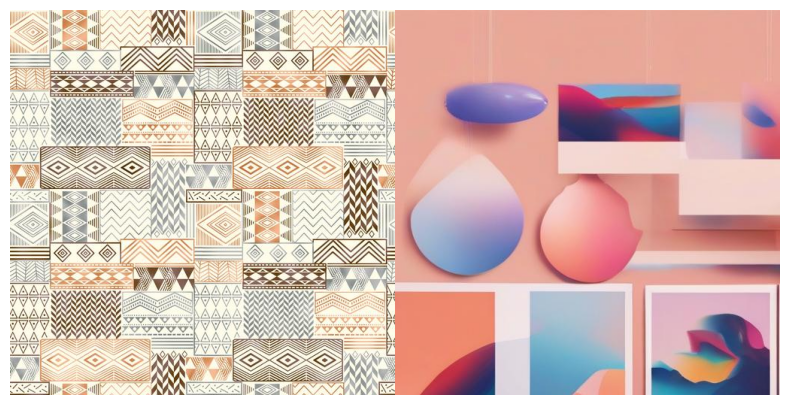

Generated image saved to s3://fashionproject/combine_images/combine_images/abstract_101_generated.jpg


In [36]:
# Example Usage
bucket_name = 'fashionproject'
image_key = 'combine_images/combine_images/abstract_101.jpg'
prompt = "Generate an image with similar aesthetics"

# Assuming 'predictor' is the object returned from the deploy method
run_inference(predictor, bucket_name, image_key, prompt)

In [37]:
predictor.delete_model()
predictor.delete_endpoint()